# Road type data to area of prediction

This notebooks integrates proximity to different road types to the area of prediction

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import rasterio
import distancerasters as dr

from joblib import Parallel, delayed
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import aup

## Data download/read and preprocessing

### Area of prediction with variables

In [2]:
aop_gdf = gpd.read_file('../../data/processed/prediccion_uso_suelo/complete_model/area_of_prediction_env.gpkg')
print(aop_gdf.shape)
aop_gdf.head(2)

(682585, 37)


,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,pobtot,...,pct_comercio,pct_cultural_recreativo,pct_educacion,pct_salud,pct_gobierno,pct_otros,temperature_mean_diff,ndvi_mean,ndmi_diff,geometry
0,Sin dato,67.279056,75GRMGQW+89PG,1412000011206018,12.438638,278416.454431,67.279056,0.000242,0.184881,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.787026,0.084339,0.045966,"MULTIPOLYGON (((2349152.724 965335.704, 234914..."
1,Sin dato,45.355545,75GRMGQW+8CFP,1412000011206018,4.482118,278416.454431,45.355545,0.000163,0.098822,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.649216,0.109751,0.045719,"MULTIPOLYGON (((2349168.91 965335.176, 2349157..."


### Area of analysis

In [3]:
aoa_gdf = gpd.read_file("../../data/processed/prediccion_uso_suelo/Distrito/distrito.shp")
aoa_gdf = aoa_gdf.to_crs("EPSG:4326")
print(aoa_gdf.shape)
aoa_gdf.head(2)

(1, 2)


,id,geometry
0,1,"POLYGON ((-103.4233 20.91026, -103.42209 20.91..."


### Edges

In [4]:
schema = "osmnx"
table = "edges_osmnx_23_line"

edges = aup.gdf_from_polygon(aoa_gdf, schema, table)
print(edges.shape)
edges.head(2)

(146103, 19)


,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
0,701379894,1742199439,1665230207,0,False,None,Privada Fresno,residential,None,85.256,"LINESTRING (-103.42168 20.58715, -103.42172 20...",None,None,None,None,None,None,None,Guadalajara
1,467372703,1873910987,1665442630,0,False,None,Avenida Los Cajetes,residential,None,68.582,"LINESTRING (-103.42383 20.58681, -103.42389 20...",None,None,None,None,None,None,None,Guadalajara


#### Road type processing

Transform lists stored as strings to list

In [5]:
from ast import literal_eval

In [6]:
def check_for_lists(val):
    try:
        val = literal_eval(val)
        return val
    except:
        return val

In [7]:
edges['highway'] = edges.highway.apply(lambda row: check_for_lists(row))

In [8]:
edges.loc[edges.highway.map(lambda x: 
                            isinstance(x, list)),'highway'] = edges.loc[
    edges.highway.map(lambda x: isinstance(x, list))].apply(
        lambda row: row['highway'][0], axis=1)

Check process

In [9]:
len(edges.loc[edges.highway.map(lambda x: 
                            isinstance(x, list))])

0

#### Remove link sections

In [10]:
edges.loc[edges['highway'].str.contains(
    "_link"),'highway'] = edges[edges['highway'].str.contains(
    "_link")].highway.apply(lambda x: x.replace('_link',''))

Check result

In [11]:
len(edges.loc[edges['highway'].str.contains(
    "_link"),'highway'])

0

In [12]:
edges.highway.unique()

array(['residential', 'primary', 'service', 'track', 'path', 'tertiary',
       'living_street', 'footway', 'cycleway', 'secondary', 'steps',
       'pedestrian', 'trunk', 'unclassified', 'motorway', 'corridor',
       'bridleway'], dtype=object)

## Road type proximity to area of analysis

Create road categories

In [13]:
road_dict = {
    'motorway':['motorway'],
    'primary':['primary'],
    'secondary':['secondary'],
    'tertiary':['tertiary'],
    'residential':['residential','living_street'],
    'other':[]
}

In [22]:
road_list = ['motorway','primary','secondary',
            'tertiary','residential','living_street']    

In [24]:
for road in edges.highway.unique():
    if road not in road_list:
        road_dict['other'].append(road)

In [36]:
edges.shape

(146103, 19)

In [35]:
edges.loc[edges.highway.isin(road_dict['other'])].shape

(38618, 19)

In [26]:
edges = edges.to_crs("EPSG:4326")
aop_gdf = aop_gdf.to_crs("EPSG:4326")

In [27]:
pixel_size = 0.00023 # 0.00023° -> 25m

In [28]:
output_dir = '../../data/processed/prediccion_uso_suelo/complete_model/prox_vialidades/'

In [29]:
if 'fid' not in list(aop_gdf.columns):
    aop_gdf = aop_gdf.reset_index().rename(columns={'index':'fid'})

In [30]:
# define bounds according to area of prediction
bounds = []
for c in aop_gdf.bounds:
    if 'min' in c:
        bounds.append(aop_gdf.bounds[c].min().item()-0.05)
    else:
        bounds.append(aop_gdf.bounds[c].max().item()+0.05)
bounds = tuple(bounds)
bounds

(-103.60543607998213,
 20.53493855031059,
 -103.27083786014029,
 20.909713137410954)

In [31]:
parallel_processing = False

In [32]:
def raster_conditional(rarray):
    return (rarray == 1)

In [37]:
def road_type_to_area_of_prediction(aop_road, edges, road_class, road_type, pixel_size, bounds, output_dir):
    
    edges_road_type = edges.loc[edges.highway.isin(road_type)].copy()

    rv_array, affine = dr.rasterize(edges_road_type, 
                                    pixel_size=pixel_size,
                                    bounds=bounds, 
                                    output=output_dir+f"{road_class}_rasterized.tif")

    # generate distance array and output to geotiff
    my_dr = dr.DistanceRaster(rv_array, affine=affine,
                          output_path=output_dir+f"{road_class}_distance.tif",
                          conditional=raster_conditional)

    raster_distance = rasterio.open(output_dir+f"{road_class}_distance.tif")

    aop_road[road_class+'_distance'] = aop_road.geometry.apply(
                lambda geom: aup.clean_mask(geom, raster_distance)).apply(np.ma.mean)

    aop_road = aop_road[['fid',road_class+'_distance']].copy()

    return aop_road


In [21]:
if parallel_processing:
    road_types = edges.highway.unique()

    results = Parallel(n_jobs=20, verbose=3)(
        delayed(road_type_to_area_of_prediction)(
            aop_gdf, edges, road_type, pixel_size, bounds, output_dir)
        for road_type in tqdm(road_types, desc="Processing roads")
    )

    for results_df in results:
        aop_gdf = aop_gdf.merge(results_df, on='fid', how='left')
        
print("Processing complete!")

Processing complete!


In [39]:
if not parallel_processing:
    results = []
    
    for road_class in tqdm(road_dict.keys(), total=len(road_dict.keys()), desc="Processing blocks"):

        road_type = road_dict[road_class]

        results.append(road_type_to_area_of_prediction(aop_gdf, edges,
                                                       road_class, road_type, 
                                                       pixel_size, bounds, output_dir)
                      )

    for results_df in results:
        aop_gdf = aop_gdf.merge(results_df, on='fid', how='left')
        
print("Processing complete!")

Processing blocks:   0%|                                                                                               | 0/6 [00:00<?, ?it/s]

Tree build time: 0.0039 seconds
Distance calc run time: 24.6686 seconds


Processing blocks:  17%|██████████████▎                                                                       | 1/6 [04:15<21:18, 255.78s/it]

Tree build time: 0.0037 seconds
Distance calc run time: 24.2663 seconds


Processing blocks:  33%|████████████████████████████▋                                                         | 2/6 [08:31<17:03, 255.89s/it]

Tree build time: 0.0039 seconds
Distance calc run time: 23.9721 seconds


Processing blocks:  50%|███████████████████████████████████████████                                           | 3/6 [12:46<12:45, 255.30s/it]

Tree build time: 0.0044 seconds
Distance calc run time: 23.5332 seconds


Processing blocks:  67%|█████████████████████████████████████████████████████████▎                            | 4/6 [17:01<08:30, 255.34s/it]

Tree build time: 0.0227 seconds
Distance calc run time: 24.5945 seconds


Processing blocks:  83%|███████████████████████████████████████████████████████████████████████▋              | 5/6 [21:21<04:16, 256.90s/it]

Tree build time: 0.0116 seconds
Distance calc run time: 24.0373 seconds


Processing blocks: 100%|██████████████████████████████████████████████████████████████████████████████████████| 6/6 [25:38<00:00, 256.36s/it]


Processing complete!


In [40]:
aop_gdf.columns

Index(['fid', 'uso_suelo', 'area_m2', 'full_plus_code', 'CVEGEO',
       'bld_area_m2', 'block_area_m2', 'pred_area_m2', 'pred_area_pct',
       'bld_pred_area_pct', 'pobtot', 'agropecuario', 'industria', 'servicios',
       'alojamiento', 'comercio', 'cultural_recreativo', 'educacion', 'salud',
       'gobierno', 'otros', 'area_m2_tot', 'habitacional', 'uso_tot',
       'pct_agropecuario', 'pct_industria', 'pct_servicios', 'pct_alojamiento',
       'pct_comercio', 'pct_cultural_recreativo', 'pct_educacion', 'pct_salud',
       'pct_gobierno', 'pct_otros', 'temperature_mean_diff', 'ndvi_mean',
       'ndmi_diff', 'geometry', 'motorway_distance_x', 'primary_distance_x',
       'secondary_distance_x', 'tertiary_distance_x', 'residential_distance_x',
       'other_distance_x', 'motorway_distance_y', 'primary_distance_y',
       'secondary_distance_y', 'tertiary_distance_y', 'residential_distance_y',
       'other_distance_y'],
      dtype='object')

In [43]:
aop_gdf = aop_gdf.drop(columns=['motorway_distance_y', 'primary_distance_y',
       'secondary_distance_y', 'tertiary_distance_y', 'residential_distance_y',
       'other_distance_y'])

aop_gdf = aop_gdf.rename(columns={'residential_distance_x':'residential_distance',
                       'primary_distance_x':'primary_distance',
                       'tertiary_distance_x':'tertiary_distance',
                       'secondary_distance_x':'secondary_distance',
                       'motorway_distance_x':'motorway_distance',
                                  'other_distance_x':'other_distance'
                       })

<Axes: >

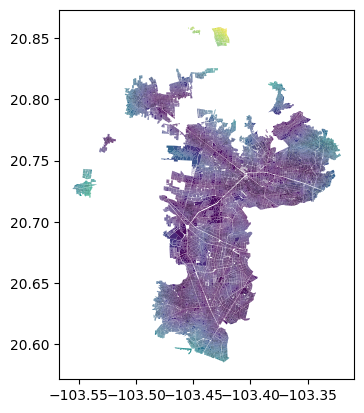

In [44]:
aop_gdf.plot('secondary_distance')

In [45]:
print(aop_gdf.shape)
aop_gdf.head(4)

(682585, 44)


,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,...,temperature_mean_diff,ndvi_mean,ndmi_diff,geometry,motorway_distance,primary_distance,secondary_distance,tertiary_distance,residential_distance,other_distance
0,0,Sin dato,67.279056,75GRMGQW+89PG,1412000011206018,12.438638,278416.454431,67.279056,0.000242,0.184881,...,1.787026,0.084339,0.045966,"MULTIPOLYGON (((-103.45405 20.68833, -103.4541...",173.493879,346.922028,83.739800,480.266657,24.764744,12.801915
1,1,Sin dato,45.355545,75GRMGQW+8CFP,1412000011206018,4.482118,278416.454431,45.355545,0.000163,0.098822,...,1.649216,0.109751,0.045719,"MULTIPOLYGON (((-103.4539 20.68833, -103.454 2...",173.493879,346.922028,83.739800,480.266657,24.764744,12.801915
2,2,Sin dato,18.488100,75GRMGQW+8CHQ,1412000011206018,4.482118,278416.454431,18.488100,0.000066,0.242433,...,1.511405,0.135162,0.045472,"MULTIPOLYGON (((-103.45387 20.68833, -103.4539...",184.217094,358.884856,95.702628,474.009254,25.603830,25.603830
3,3,Sin dato,4.936089,75GRMGQW+8GCG,1412000011206018,42.992618,278416.454431,4.936089,0.000018,8.709855,...,1.511405,0.135162,0.045472,"MULTIPOLYGON (((-103.45381 20.68832, -103.4538...",195.213414,370.847685,107.665457,468.201909,25.603830,25.603830


## Save data

In [46]:
aop_gdf.to_file('../../data/processed/prediccion_uso_suelo/complete_model/area_of_prediction_roads.gpkg')